<a href="https://colab.research.google.com/github/aarthiindukuri/BraintumourProject/blob/main/Brain_Tumour_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
from sklearn.metrics import accuracy_score
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D,Flatten, Dense, Dropout, BatchNormalization, Input,RandomRotation,RandomFlip,RandomContrast
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
import os
import cv2
# from pyswarm import pso

In [ ]:
!pip install --upgrade tensorflow


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir  ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 94% 140M/149M [00:01<00:00, 141MB/s]
100% 149M/149M [00:01<00:00, 136MB/s]


In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/brain-tumor-mri-dataset.zip')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [ ]:
import os
glioma_path ='/content/dataset/Training/glioma'
meningioma_path='/content/dataset/Training/meningioma'
notumor_path='/content/dataset/Training/notumor'
pituitary_path='/content/dataset/Training/pituitary'
img_classes = ["Glioma cases", "Meningioma cases", "Notumor cases","Pituitary cases"]
path_list = [glioma_path, meningioma_path, notumor_path,pituitary_path]
img_path = []
class_labels = []
for i, dir_list in enumerate(path_list):
    name_img = os.listdir(dir_list)
    for name_file in name_img:
        img = os.path.join(dir_list,name_file)
        img_path.append(img)
        class_labels.append(img_classes[i])

data = pd.DataFrame({"img_path" : img_path,
                  "label" : class_labels})
data.head()

img_path         label
0  /content/dataset/Training/glioma/Tr-gl_0490.jpg  Glioma cases
1  /content/dataset/Training/glioma/Tr-gl_0220.jpg  Glioma cases
2  /content/dataset/Training/glioma/Tr-gl_1172.jpg  Glioma cases
3  /content/dataset/Training/glioma/Tr-gl_0970.jpg  Glioma cases
4  /content/dataset/Training/glioma/Tr-gl_0476.jpg  Glioma cases

# KAGGLE

In [ ]:
classes=[]
filename='/content/dataset'
for sub_folder in os.listdir(os.path.join(filename,'Training')):
    classes.append(sub_folder)
print(classes)

['notumor', 'pituitary', 'glioma', 'meningioma']


In [ ]:
train_path='/content/dataset/Training/'
test_path='/content/dataset/Testing/'

In [ ]:
img_list=[]
label_list=[]
for label in classes:
    for img_file in os.listdir(train_path+label):
        img_list.append(train_path+label+'/'+img_file)
        label_list.append(label)

In [ ]:
train_data = pd.DataFrame({'Image':img_list,'Label':label_list})
train_data

Image       Label
0      /content/dataset/Training/notumor/Tr-no_0643.jpg     notumor
1      /content/dataset/Training/notumor/Tr-no_1578.jpg     notumor
2      /content/dataset/Training/notumor/Tr-no_1481.jpg     notumor
3      /content/dataset/Training/notumor/Tr-no_0841.jpg     notumor
4      /content/dataset/Training/notumor/Tr-no_0694.jpg     notumor
...                                                 ...         ...
5707  /content/dataset/Training/meningioma/Tr-me_108...  meningioma
5708  /content/dataset/Training/meningioma/Tr-me_003...  meningioma
5709  /content/dataset/Training/meningioma/Tr-me_024...  meningioma
5710  /content/dataset/Training/meningioma/Tr-me_089...  meningioma
5711  /content/dataset/Training/meningioma/Tr-me_114...  meningioma

[5712 rows x 2 columns]

In [ ]:
img_list=[]
label_list=[]
for label in classes:
    for img_file in os.listdir(test_path+label):
        img_list.append(test_path+label+'/'+img_file)
        label_list.append(label)

In [ ]:
test_data = pd.DataFrame({'Image':img_list,'Label':label_list})
test_data

Image       Label
0       /content/dataset/Testing/notumor/Te-no_0182.jpg     notumor
1       /content/dataset/Testing/notumor/Te-no_0277.jpg     notumor
2       /content/dataset/Testing/notumor/Te-no_0329.jpg     notumor
3       /content/dataset/Testing/notumor/Te-no_0166.jpg     notumor
4       /content/dataset/Testing/notumor/Te-no_0267.jpg     notumor
...                                                 ...         ...
1306  /content/dataset/Testing/meningioma/Te-me_0267...  meningioma
1307  /content/dataset/Testing/meningioma/Te-me_0190...  meningioma
1308  /content/dataset/Testing/meningioma/Te-me_0217...  meningioma
1309  /content/dataset/Testing/meningioma/Te-me_0083...  meningioma
1310  /content/dataset/Testing/meningioma/Te-me_0237...  meningioma

[1311 rows x 2 columns]

In [ ]:
def Plot_Classes(BASE_URL, Rows=2, Columns=5):

  plt.figure(figsize = (25, 8))
  image_count = 1

  for directory in os.listdir(BASE_URL):

      if directory[0] != '.':

          Max_Random = len(os.listdir(os.path.join(BASE_URL,directory)))

          Random_Number = np.random.randint(0, Max_Random)

          for i, file in enumerate(os.listdir(BASE_URL + directory)):

              if i == Random_Number:

                  fig = plt.subplot(Rows, Columns, image_count)
                  image_count += 1

                  image = plt.imread(BASE_URL + directory + '/' + file)
                  plt.imshow(image)

                  plt.title(directory)

                  break

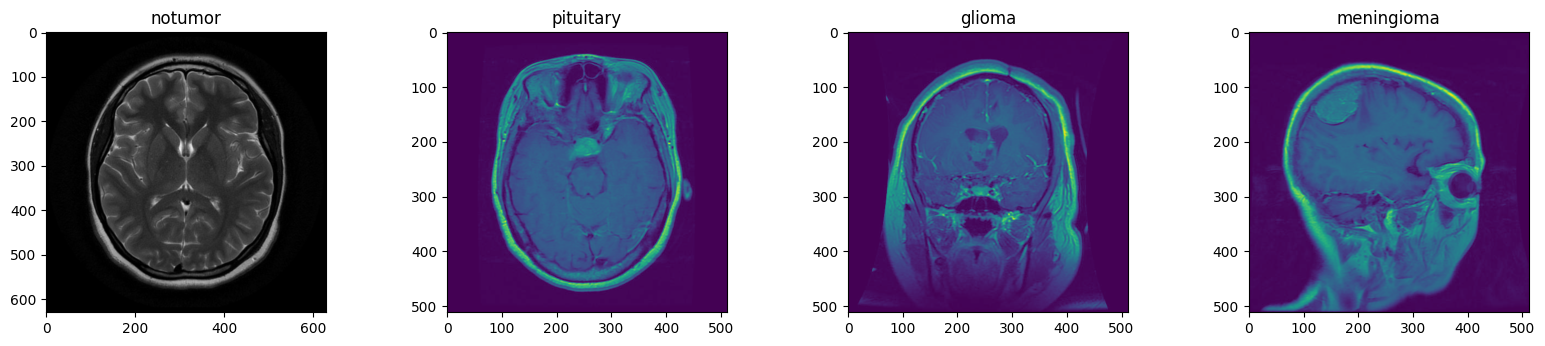

In [ ]:
Plot_Classes(train_path)

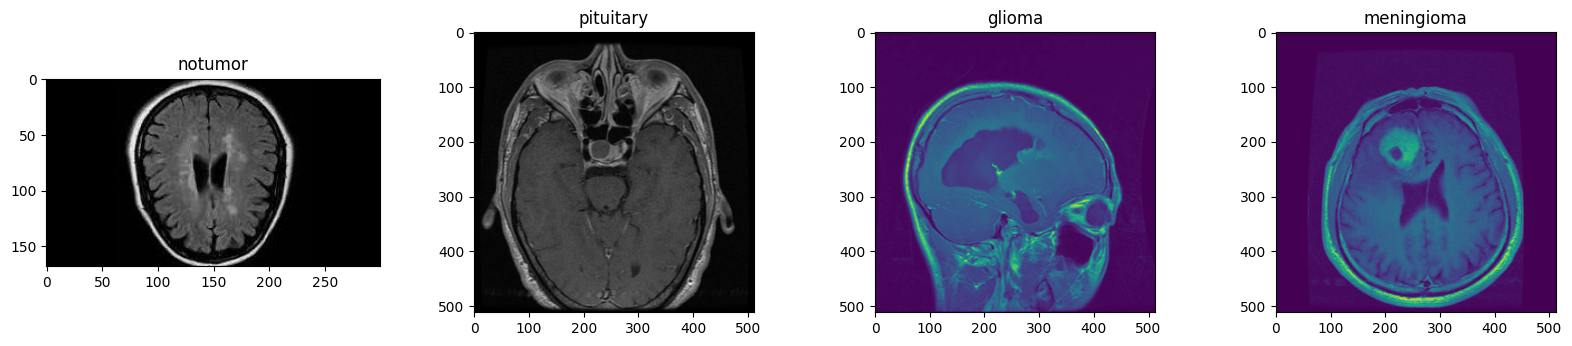

In [ ]:
Plot_Classes(test_path)

In [ ]:
train_data['Label'].value_counts()

Label
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64

In [ ]:
px.histogram(train_data, y="Label", color="Label", title="Classes Distribution")

In [ ]:
test_data['Label'].value_counts()

Label
notumor       405
meningioma    306
pituitary     300
glioma        300
Name: count, dtype: int64

In [ ]:
px.histogram(test_data, y="Label", color="Label", title="Classes Distribution")

In [ ]:
# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

In [ ]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.15,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)

# Creating training data generator
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    seed=0)

# Creating validation data generator
val_generator = val_datagen.flow_from_directory(train_path,
                                                target_size=image_size,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                subset='validation',
                                                seed=0)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=0)

Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
def show_ImageDataGenerator(ImageDataGenerator, num_samples=5, figsize=(12, 12), save=False):
    """
    Function to viusalize how the ImageDataGenerator augments the data
    """

    # Generate augmented samples
    # Use __next__() instead of next()
    augmented_samples = train_generator.__next__()

    # Extract images from the batch
    images = augmented_samples[0][:num_samples]

    # Display the augmented images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')

    plt.tight_layout()

    if save:
        plt.savefig('show_ImageDataGenerator.pdf')

    plt.show()

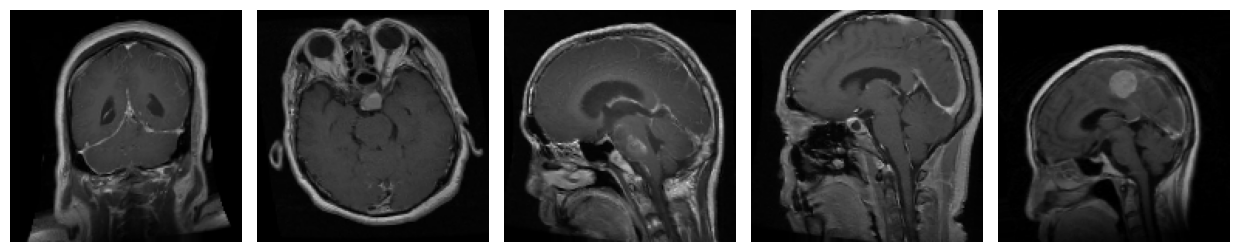

In [ ]:
show_ImageDataGenerator(train_datagen, num_samples=5, figsize=(12.5, 8), save=False)

In [ ]:

# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)


print(f'Image shape: {image_shape}')
print(f'Batch size: {batch_size}')
print(f'Number of Train batches: {len(train_generator)}')
print(f'Number of Validation batches: {len(val_generator)}')
print(f'Number of Testing batches: {len(test_generator)}')

Image shape: (150, 150, 3)
Batch size: 32
Number of Train batches: 152
Number of Validation batches: 27
Number of Testing batches: 41


In [ ]:
Classes_Map = train_generator.class_indices

num_classes = len(Classes_Map)

print("Number of Classes:", num_classes)
Classes_Map

Number of Classes: 4


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [ ]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.figure(figsize=(15,5))
  plt.style.use('ggplot')


  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, 'bo-' , label = "TrainL oss")
  plt.plot(epochs, val_loss, 'o-' , color='orange', label = "Val Loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()


  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, 'bo-' , label = "Train Acc")
  plt.plot(epochs, val_accuracy, 'o-' , color='orange' , label = "Val Acc")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()

  plt.style.use('default')

In [ ]:
def CM(model, test_generator, categories):
    """
    Function to return the confusion matrix of a given CNN model.
    """
    from sklearn.metrics import confusion_matrix
    # Predictions on test dataset
    predictions = model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Create a confusion matrix
    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)
    print(f"Classification Report for {model}:")
    print(classification_report(true_categories, predicted_categories, target_names=categories))

    return confusion_matrix_array


def calculate_metrics(confusion_matrix, categories):
    """
    Function to calculate important metrics for multi-classification problems.
    """
    # Calculating 4 different metrics
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    # Printing the results based on each category
    for i, category in enumerate(categories):
        print(f"Class: {category.title()}")
        print(f"Precision: {precision[i]:.3f}")
        print(f"Recall: {recall[i]:.3f}")
        print(f"F1-Score: {f1_score[i]:.3f}\n")

    # Showing the total accuracy of the model
    print(f"\nAccuracy: {accuracy:.3f}")

CNN MODEL

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

def create_cnn_model(input_shape, num_classes):
    model = Sequential()

    # Define input layer
    model.add(Input(shape=input_shape))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define example input shape and number of classes
image_shape = (150, 150, 3)  # example image shape
num_classes = 4 # example number of classes

cnn_model = create_cnn_model(input_shape=image_shape, num_classes=num_classes)
cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,454,660 (13.18 MB)

 Trainable params: 3,454,660 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_history = cnn_model.fit(train_generator,epochs=30,validation_data=val_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 49s 270ms/step - accuracy: 0.5793 - loss: 0.9638 - val_accuracy: 0.7591 - val_loss: 0.6802
Epoch 2/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 237ms/step - accuracy: 0.7857 - loss: 0.5095 - val_accuracy: 0.7696 - val_loss: 0.6357
Epoch 3/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 38s 248ms/step - accuracy: 0.8475 - loss: 0.3964 - val_accuracy: 0.8070 - val_loss: 0.4891
Epoch 4/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 37s 242ms/step - accuracy: 0.8620 - loss: 0.3521 - val_accuracy: 0.8327 - val_loss: 0.4828
Epoch 5/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 38s 248ms/step - accuracy: 0.8906 - loss: 0.2953 - val_accuracy: 0.8620 - val_loss: 0.4276
Epoch 6/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 37s 241ms/step - accuracy: 0.9097 - loss: 0.2385 - val_accuracy: 0.8737 - val_loss: 0.3829
Epoch 7/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - accuracy: 0.9290 - loss: 0.1914 - val_accuracy: 0.8959 - val_loss: 0.3539
Epoch 8/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 37s 242ms/step - accuracy: 0.9352 - loss: 0

KeyboardInterrupt: 

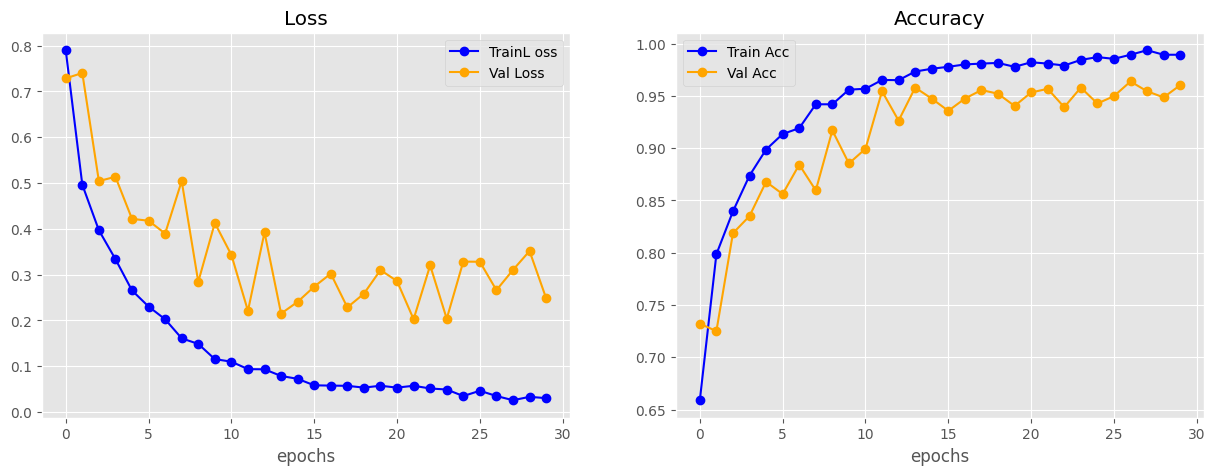

In [ ]:
plot_curves(cnn_history)

In [ ]:
loss, accuracy = cnn_model.evaluate(test_generator)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.9509 - loss: 0.2549
Test Loss: 0.17357
Test Accuracy: 0.96949


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
Classification Report for sequential:
              precision    recall  f1-score   support

     notumor       0.99      0.95      0.97       300
  meningioma       0.95      0.93      0.94       306
      glioma       0.97      1.00      0.98       405
   pituitary       0.96      0.99      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



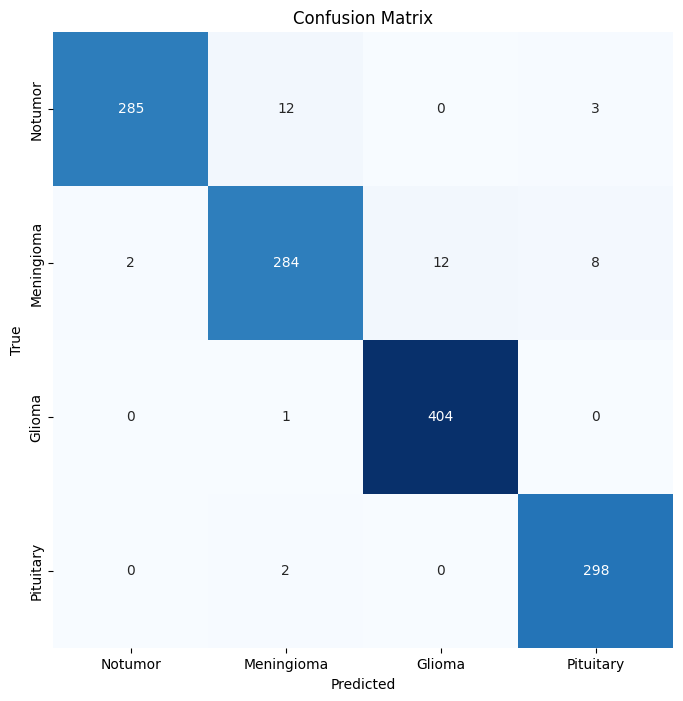

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def CM(model, test_generator, categories):
    # Get predictions and true labels
    predictions = model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Compute confusion matrix and classification report
    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)
    print(f"Classification Report for {model.name}:")
    print(classification_report(true_categories, predicted_categories, target_names=categories))

    return confusion_matrix_array

# Generate the confusion matrix
confusion_matrix = CM(model=cnn_model, test_generator=test_generator, categories=classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(classes)) + 0.5,
           labels=[name.title() for name in classes], ha='center')
plt.yticks(ticks=np.arange(len(classes)) + 0.5,
           labels=[name.title() for name in classes], va='center')
plt.show()


VGG16 MODEL

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


for layer in base_model_vgg.layers[:-10]:
    layer.trainable = False

for layer in base_model_vgg.layers[-10:]:
    layer.trainable = True

# Add custom classification head
x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model_vgg = Model(inputs=base_model_vgg.input, outputs=output)

model_vgg.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model_vgg.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,6

 Total params: 14,979,396 (57.14 MB)

 Trainable params: 13,833,988 (52.77 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

In [ ]:
vgg_history = model_vgg.fit(train_generator,epochs=20,validation_data=val_generator)

Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 87s 457ms/step - accuracy: 0.6610 - loss: 0.7898 - val_accuracy: 0.8643 - val_loss: 0.4047
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 109s 330ms/step - accuracy: 0.9049 - loss: 0.2590 - val_accuracy: 0.8713 - val_loss: 0.3527
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 50s 327ms/step - accuracy: 0.9401 - loss: 0.1770 - val_accuracy: 0.8936 - val_loss: 0.2850
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 82s 329ms/step - accuracy: 0.9525 - loss: 0.1370 - val_accuracy: 0.9240 - val_loss: 0.2172
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 51s 337ms/step - accuracy: 0.9698 - loss: 0.0837 - val_accuracy: 0.9368 - val_loss: 0.2210
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 51s 337ms/step - accuracy: 0.9744 - loss: 0.0818 - val_accuracy: 0.9556 - val_loss: 0.2053
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 49s 320ms/step - accuracy: 0.9797 - loss: 0.0598 - val_accuracy: 0.9263 - val_loss: 0.2581
Epoch 8/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 83s 328ms/step - accuracy: 0.9699 - loss: 

VGG16 MODEL EVALUATION

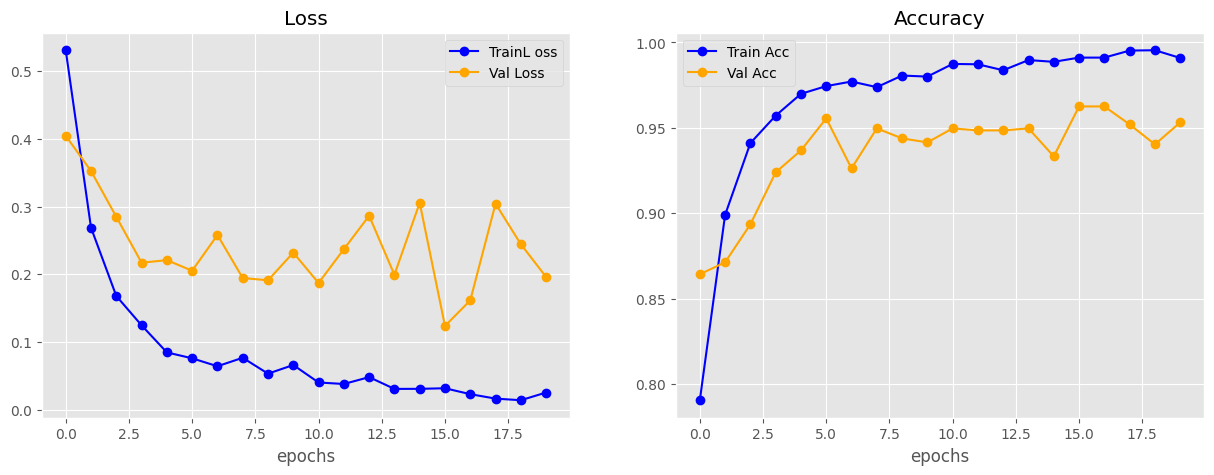

In [ ]:
plot_curves(vgg_history)

In [ ]:
loss, accuracy = model_vgg.evaluate(test_generator)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 273ms/step - accuracy: 0.9458 - loss: 0.2273
Test Loss: 0.16233
Test Accuracy: 0.96034


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step
Classification Report for functional_12:
              precision    recall  f1-score   support

     notumor       0.97      0.98      0.97       300
  meningioma       0.99      0.87      0.92       306
      glioma       0.93      1.00      0.96       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



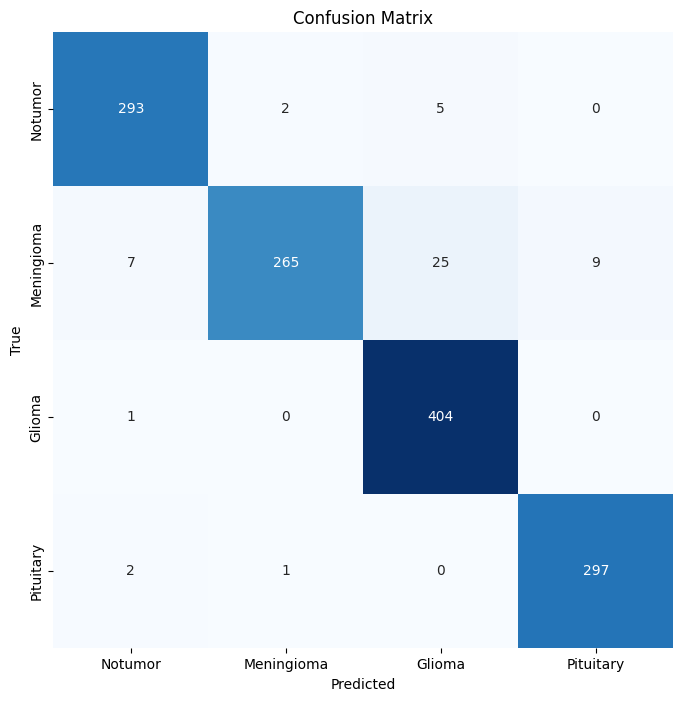

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def CM(model, test_generator, categories):
    # Get predictions and true labels
    predictions = model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Compute confusion matrix and classification report
    cm_array = confusion_matrix(true_categories, predicted_categories)  # Renamed variable
    print(f"Classification Report for {model.name}:")
    print(classification_report(true_categories, predicted_categories, target_names=categories))

    return cm_array

# Generate the confusion matrix
cm_array = CM(model=model_vgg, test_generator=test_generator, categories=classes)  # Renamed variable

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm_array, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(classes)) + 0.5,
           labels=[name.title() for name in classes], ha='center')
plt.yticks(ticks=np.arange(len(classes)) + 0.5,
           labels=[name.title() for name in classes], va='center')
plt.show()

RESNET101 MODEL

In [ ]:

from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


base_model_resnet = ResNet101(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


# for layer in base_model_resnet.layers[:-10]:
#     layer.trainable = False

# for layer in base_model_resnet.layers[-10:]:
#     layer.trainable = True


# Add custom classification head
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model_resnet = Model(inputs=base_model_resnet.input, outputs=output)

model_resnet.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model_resnet.summary()

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 156, 156, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 38, 38, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 38, 38, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 38, 38, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 43,709,316 (166.74 MB)

 Trainable params: 43,603,972 (166.34 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [ ]:
resnet_history = model_resnet.fit(train_generator,epochs=20,validation_data=val_generator)

NameError: name 'model_resnet' is not defined

RESNET MODEL EVALUATION

In [ ]:
plot_curves(resnet_history)

NameError: name 'plot_curves' is not defined

In [ ]:
loss, accuracy = model_resnet.evaluate(test_generator)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - accuracy: 0.9908 - loss: 0.0324
Test Loss: 0.03774
Test Accuracy: 0.98932


41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 260ms/step
Classification Report for functional_38:
              precision    recall  f1-score   support

   pituitary       0.97      1.00      0.98       300
     notumor       0.99      0.97      0.98       306
      glioma       0.99      1.00      1.00       405
  meningioma       1.00      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



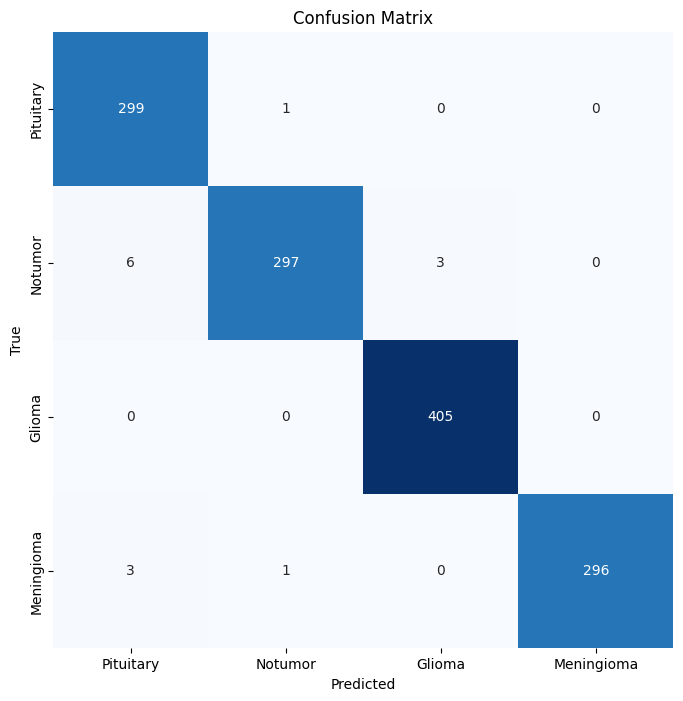

In [ ]:
# Plotting confusion matrix
confusion_matrix = CM(model=model_resnet, test_generator=test_generator, categories=classes)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], ha='center')
plt.yticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], va='center')
plt.show()

{'pituitary': 0.014, 'notumor': 99.929, 'glioma': 0.002, 'meningioma': 0.055}
{'pituitary': 0.0, 'notumor': 100.0, 'glioma': 0.0, 'meningioma': 0.0}
{'pituitary': 0.008, 'notumor': 74.824, 'glioma': 0.009, 'meningioma': 25.159}
{'pituitary': 0.0, 'notumor': 100.0, 'glioma': 0.0, 'meningioma': 0.0}
{'pituitary': 4.739, 'notumor': 48.923, 'glioma': 0.02, 'meningioma': 46.319}
{'pituitary': 0.001, 'notumor': 99.998, 'glioma': 0.0, 'meningioma': 0.001}
{'pituitary': 0.0, 'notumor': 100.0, 'glioma': 0.0, 'meningioma': 0.0}
{'pituitary': 0.0, 'notumor': 100.0, 'glioma': 0.0, 'meningioma': 0.0}
{'pituitary': 0.0, 'notumor': 100.0, 'glioma': 0.0, 'meningioma': 0.0}
{'pituitary': 0.597, 'notumor': 99.16, 'glioma': 0.006, 'meningioma': 0.237}


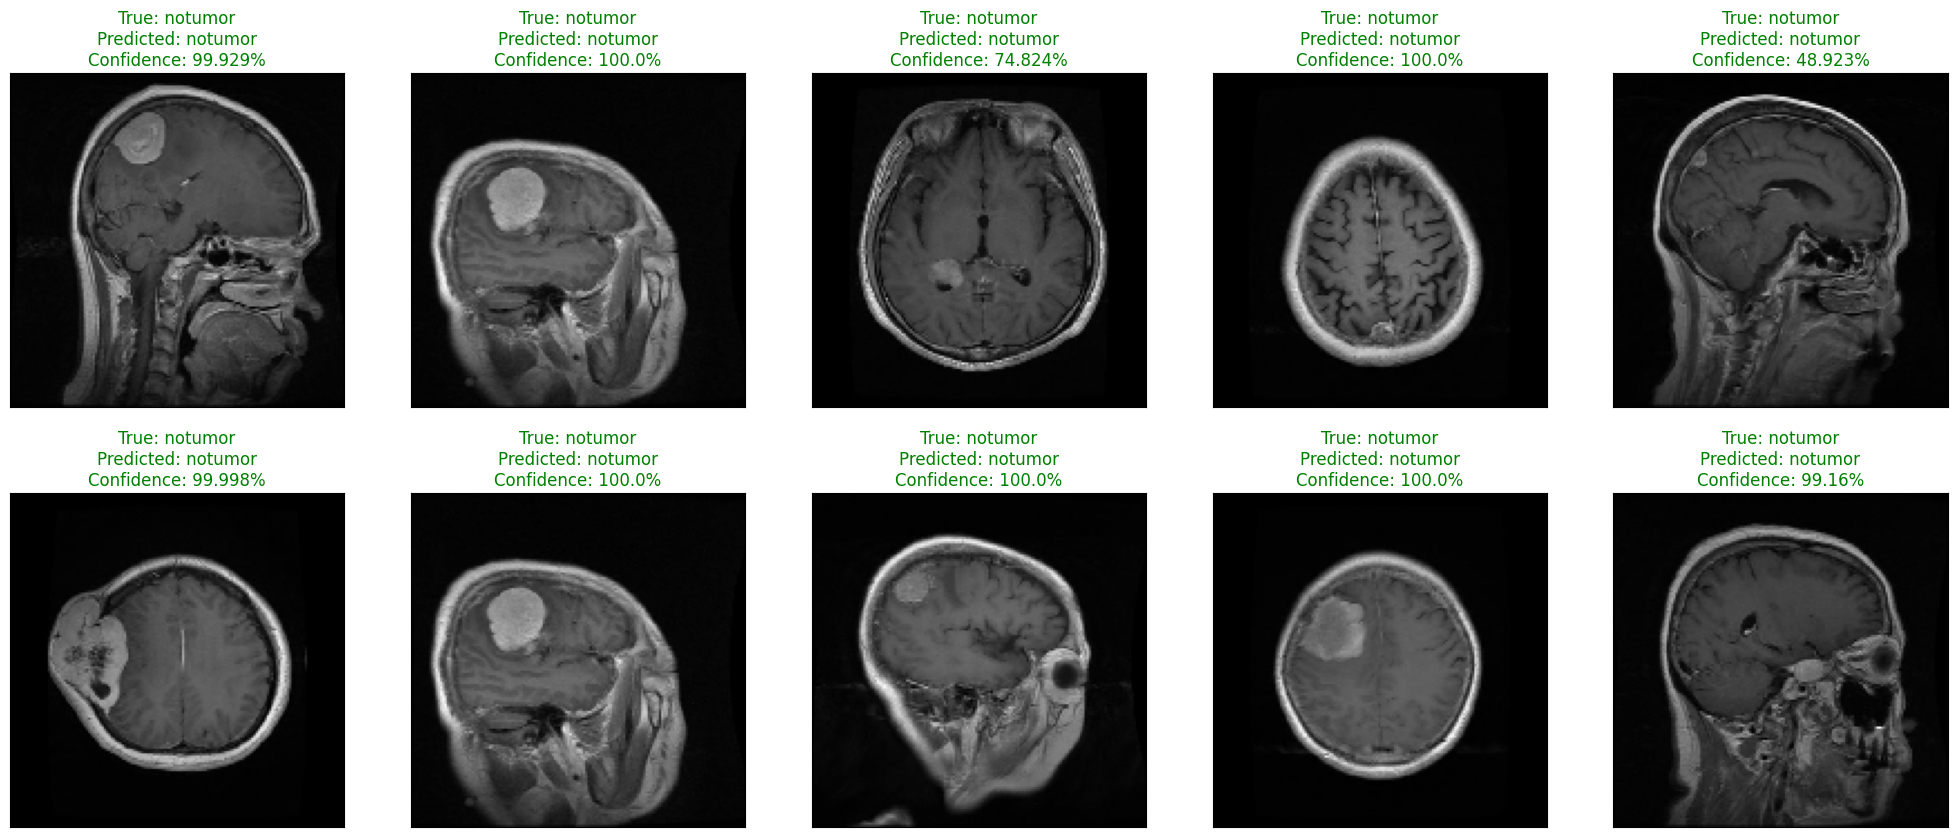

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 10 random pictures predictions from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator))

Random_Img_Index = np.random.randint(0, batch_size , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Predictions = model_resnet.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0)

    Model_Highest_Prediction = np.argmax(Model_Predictions)

    Model_Predictions_Map = { c: round(p*100,3) for (c,p) in zip (classes, Model_Predictions.tolist()[0] ) }

    ax.imshow(Random_Img)

    Pred_Class = classes[Model_Highest_Prediction]

    if classes[Random_Img_Label] == Pred_Class:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {classes[Random_Img_Label]}\nPredicted: {Pred_Class}\nConfidence: {Model_Predictions_Map[Pred_Class]}%",
          color=color)
    print(Model_Predictions_Map)
plt.show()
plt.tight_layout()


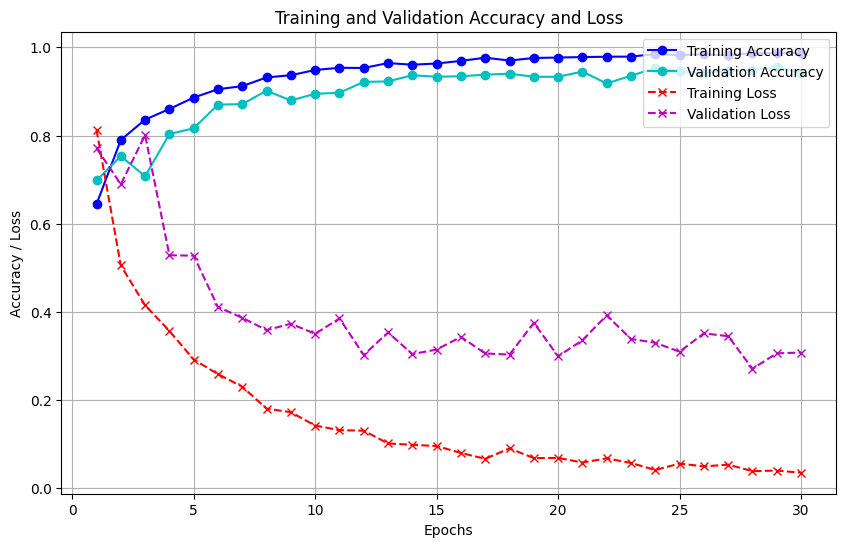

In [ ]:
import matplotlib.pyplot as plt

# Extracting accuracy and loss values from the training history
acc = cnn_history.history['accuracy']
val_acc = cnn_history.history['val_accuracy']
loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting accuracy and loss on the same graph
plt.figure(figsize=(10, 6))

# Plot accuracy
plt.plot(epochs, acc, label='Training Accuracy', color='b', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='c', marker='o')

# Plot loss on secondary y-axis
plt.plot(epochs, loss, label='Training Loss', color='r', linestyle='--', marker='x')
plt.plot(epochs, val_loss, label='Validation Loss', color='m', linestyle='--', marker='x')

# Labels and title
plt.title("Training and Validation Accuracy and Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy / Loss")
plt.legend(loc="upper right")

plt.grid(True)
plt.show()


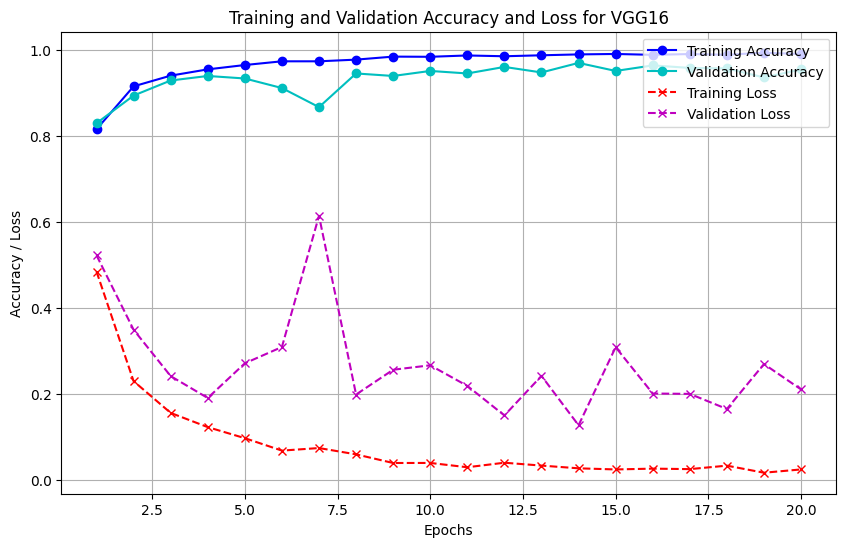

In [ ]:
import matplotlib.pyplot as plt

# Assuming the training history is saved in `vgg_history`
acc = vgg_history.history['accuracy']
val_acc = vgg_history.history['val_accuracy']
loss = vgg_history.history['loss']
val_loss = vgg_history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting accuracy and loss on the same graph
plt.figure(figsize=(10, 6))

# Plot accuracy
plt.plot(epochs, acc, label='Training Accuracy', color='b', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='c', marker='o')

# Plot loss
plt.plot(epochs, loss, label='Training Loss', color='r', linestyle='--', marker='x')
plt.plot(epochs, val_loss, label='Validation Loss', color='m', linestyle='--', marker='x')

# Labels and title
plt.title("Training and Validation Accuracy and Loss for VGG16")
plt.xlabel("Epochs")
plt.ylabel("Accuracy / Loss")
plt.legend(loc="upper right")

plt.grid(True)
plt.show()


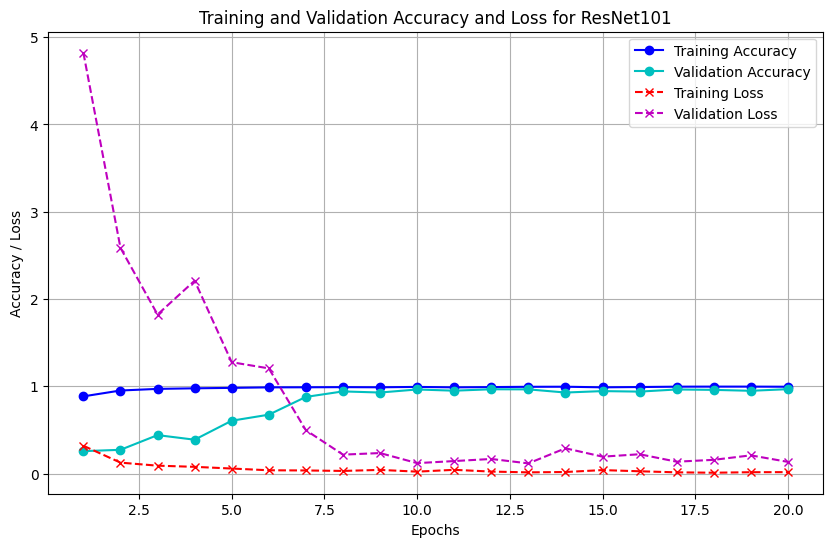

In [ ]:
import matplotlib.pyplot as plt

# Assuming the training history is saved in `resnet_history`
acc = resnet_history.history['accuracy']
val_acc = resnet_history.history['val_accuracy']
loss = resnet_history.history['loss']
val_loss = resnet_history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting accuracy and loss on the same graph
plt.figure(figsize=(10, 6))

# Plot accuracy
plt.plot(epochs, acc, label='Training Accuracy', color='b', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='c', marker='o')

# Plot loss
plt.plot(epochs, loss, label='Training Loss', color='r', linestyle='--', marker='x')
plt.plot(epochs, val_loss, label='Validation Loss', color='m', linestyle='--', marker='x')

# Labels and title
plt.title("Training and Validation Accuracy and Loss for ResNet101")
plt.xlabel("Epochs")
plt.ylabel("Accuracy / Loss")
plt.legend(loc="upper right")

plt.grid(True)
plt.show()


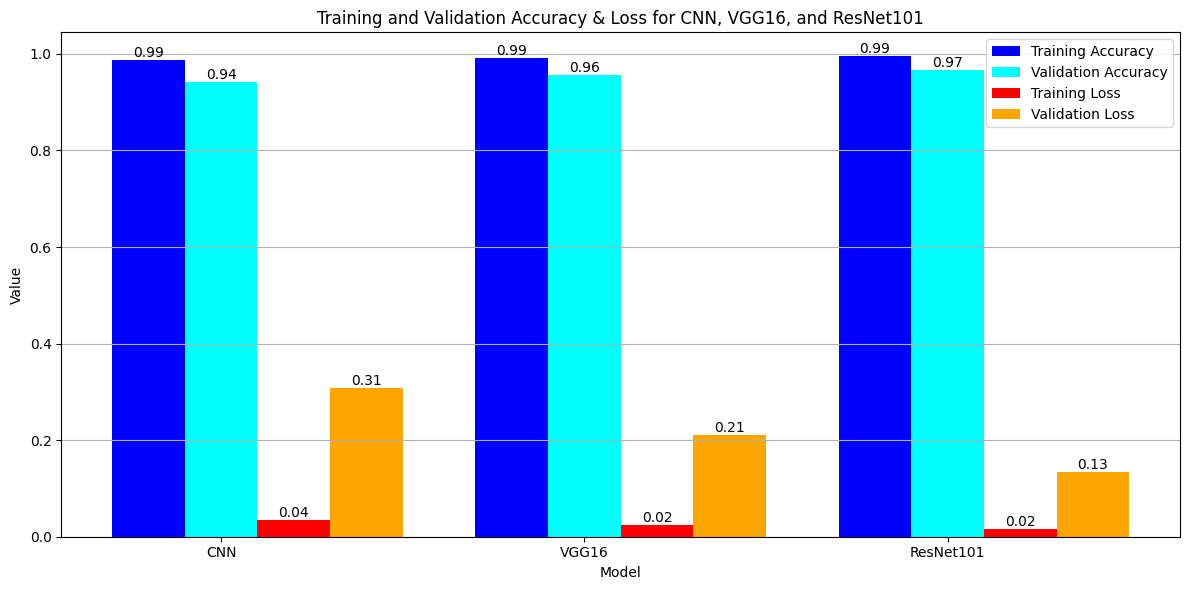

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming cnn_history, vgg_history, and resnet_history are available and contain the training history

def plot_model_performance(cnn_history, vgg_history, resnet_history):
    try:
        # Extract accuracy and loss values
        train_acc = [
            cnn_history.history['accuracy'][-1],
            vgg_history.history['accuracy'][-1],
            resnet_history.history['accuracy'][-1]
        ]

        val_acc = [
            cnn_history.history['val_accuracy'][-1],
            vgg_history.history['val_accuracy'][-1],
            resnet_history.history['val_accuracy'][-1]
        ]

        train_loss = [
            cnn_history.history['loss'][-1],
            vgg_history.history['loss'][-1],
            resnet_history.history['loss'][-1]
        ]

        val_loss = [
            cnn_history.history['val_loss'][-1],
            vgg_history.history['val_loss'][-1],
            resnet_history.history['val_loss'][-1]
        ]

        models = ['CNN', 'VGG16', 'ResNet101']

        # Set up bar positions
        bar_width = 0.2
        x = np.arange(len(models))

        # Create the bar graph
        plt.figure(figsize=(12, 6))

        # Accuracy bars
        bars1 = plt.bar(x - bar_width, train_acc, width=bar_width, label='Training Accuracy', color='blue')
        bars2 = plt.bar(x, val_acc, width=bar_width, label='Validation Accuracy', color='cyan')

        # Loss bars
        bars3 = plt.bar(x + bar_width, train_loss, width=bar_width, label='Training Loss', color='red')
        bars4 = plt.bar(x + 2 * bar_width, val_loss, width=bar_width, label='Validation Loss', color='orange')

        # Add percentage values on top of bars
        for bar in bars1 + bars2 + bars3 + bars4:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom' if yval >= 0 else 'top')

        # Labels and Title
        plt.xlabel('Model')
        plt.ylabel('Value')
        plt.title('Training and Validation Accuracy & Loss for CNN, VGG16, and ResNet101')
        plt.xticks(ticks=x, labels=models)
        plt.legend(loc='best')
        plt.grid(True, axis='y')

        plt.tight_layout()
        plt.show()

    except KeyError as e:
        print(f"KeyError: {e}. Ensure the required metrics exist in the history object.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Call the function to plot the performance
plot_model_performance(cnn_history, vgg_history, resnet_history)


MOBILENET


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import Input

def create_mobilenet_model(input_shape, num_classes):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Freeze the base model layers to retain pre-trained features
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define example input shape and number of classes
image_shape = (150, 150, 3)  # example image shape
num_classes = 4  # example number of classes

mobilenet_model = create_mobilenet_model(input_shape=image_shape, num_classes=num_classes)
mobilenet_model.summary()


<ipython-input-32-2dd5089a1cac>:9: UserWarning:

`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,915,908 (11.12 MB)

 Trainable params: 657,924 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
mobilenet_history = mobilenet_model.fit(train_generator, epochs=30, validation_data=val_generator)


Epoch 1/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 54s 297ms/step - accuracy: 0.7399 - loss: 0.7637 - val_accuracy: 0.7743 - val_loss: 0.5971
Epoch 2/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 38s 248ms/step - accuracy: 0.8640 - loss: 0.3550 - val_accuracy: 0.6936 - val_loss: 0.9715
Epoch 3/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 235ms/step - accuracy: 0.8869 - loss: 0.3080 - val_accuracy: 0.8164 - val_loss: 0.5072
Epoch 4/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 35s 230ms/step - accuracy: 0.9061 - loss: 0.2703 - val_accuracy: 0.7848 - val_loss: 0.6494
Epoch 5/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 42s 240ms/step - accuracy: 0.9031 - loss: 0.2510 - val_accuracy: 0.8199 - val_loss: 0.4988
Epoch 6/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - accuracy: 0.9088 - loss: 0.2480 - val_accuracy: 0.8117 - val_loss: 0.5782
Epoch 7/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 234ms/step - accuracy: 0.9122 - loss: 0.2414 - val_accuracy: 0.8421 - val_loss: 0.4674
Epoch 8/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 234ms/step - accuracy: 0.9246 - loss: 0

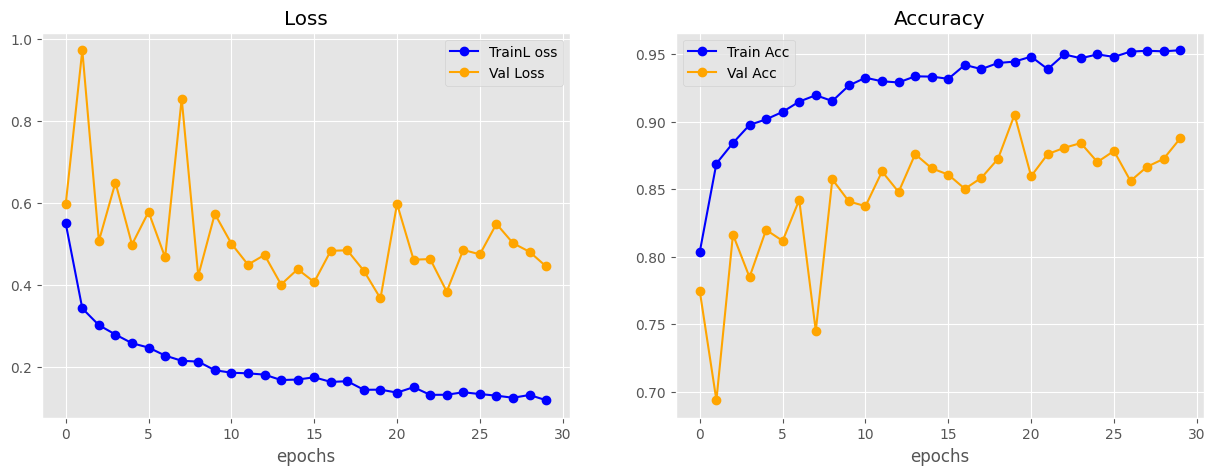

In [ ]:
plot_curves(mobilenet_history)

In [ ]:
loss, accuracy = mobilenet_model.evaluate(test_generator)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9062 - loss: 0.2488

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.8804 - loss: 0.3488
Test Loss: 0.24109
Test Accuracy: 0.92220


THE END

In [ ]:
data['label'].value_counts()

label
Notumor cases       1595
Pituitary cases     1457
Meningioma cases    1339
Glioma cases        1321
Name: count, dtype: int64

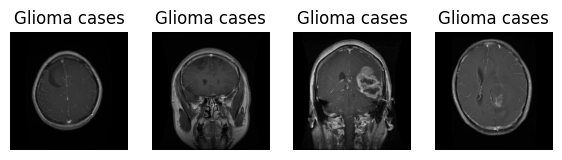

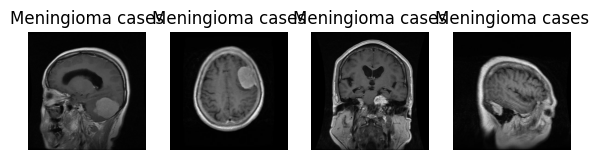

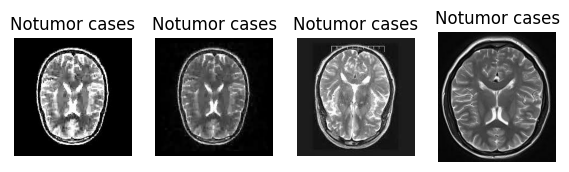

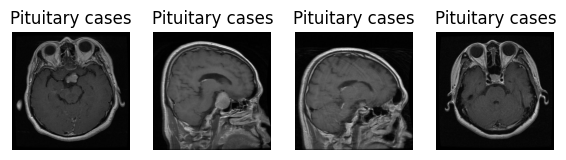

In [ ]:
for category, group in data.groupby("label"):
    fig, ax = plt.subplots(1,4, figsize = (7,7))
    ax = ax.ravel()
    for i, (_,r) in enumerate(group.sample(4).iterrows()):
        img = cv2.imread(r.img_path)
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title(r.label)
    plt.show()

In [ ]:
train_ratio = 0.70
test_ratio = 0.15
val_ratio = 0.15

df_train, df_test_val = train_test_split(data, train_size = train_ratio, random_state = 42)
df_test, df_val = train_test_split(df_test_val, train_size = test_ratio/(test_ratio+val_ratio), random_state = 42)

print(f"Train shape = {df_train.shape}")
print(f"Test shape = {df_test.shape}")
print(f"Validation shape = {df_val.shape}")

Train shape = (3998, 2)
Test shape = (857, 2)
Validation shape = (857, 2)


In [ ]:
def preprocessing_denoise(img):
    denoise_img = cv2.medianBlur(img, 1)
    denoise_img = cv2.cvtColor(denoise_img, cv2.COLOR_BGR2RGB)
    return denoise_img

In [ ]:
# IMG_WIDTH = 256
# IMG_HEIGHT = 256
# image_size = (IMG_WIDTH, IMG_HEIGHT)
# batch_size = 32

# TRAIN_DATAGEN = ImageDataGenerator(rescale = 1./255.,
#                                   preprocessing_function = preprocessing_denoise,
#                                   rotation_range = 30,
#                                   width_shift_range = 0.1,
#                                   height_shift_range = 0.2,
#                                   shear_range = 0.1,
#                                   zoom_range = 0.2,
#                                   horizontal_flip = True)

# TEST_DATAGEN = ImageDataGenerator(rescale = 1./255.)

# train_dataset = TRAIN_DATAGEN.flow_from_dataframe(
#     df_train,
#     x_col = "img_path",
#     y_col = "label",
#     target_size = image_size,
#     batch_size = batch_size,
#     color_mode = "rgb",
#     class_mode = "categorical",
#     shuffle = True
# )

# val_dataset = TEST_DATAGEN.flow_from_dataframe(
#     df_val,
#     x_col = "img_path",
#     y_col = "label",
#     target_size = image_size,
#     batch_size = batch_size,
#     color_mode = "rgb",
#     class_mode = "categorical",
#     shuffle = True
# )

# test_dataset = TEST_DATAGEN.flow_from_dataframe(
#     df_test,
#     x_col = "img_path",
#     y_col = "label",
#     target_size = image_size,
#     batch_size = batch_size,
#     color_mode = "rgb",
#     class_mode = "categorical",
#     shuffle = True
# )

IMG_WIDTH = 256
IMG_HEIGHT = 256
image_size = (IMG_WIDTH, IMG_HEIGHT)
batch_size = 32

TRAIN_DATAGEN = ImageDataGenerator(rescale = 1./255.,
                                  preprocessing_function = preprocessing_denoise,
                                  rotation_range = 30,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.2,
                                  shear_range = 0.1,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

TEST_DATAGEN = ImageDataGenerator(rescale = 1./255.)

train_dataset = TRAIN_DATAGEN.flow_from_dataframe(
    df_train,
    x_col = "img_path",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "categorical",
    shuffle = True  # Shuffling is fine for training
)

val_dataset = TEST_DATAGEN.flow_from_dataframe(
    df_val,
    x_col = "img_path",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "categorical",
    shuffle = True  # Shuffling for validation is okay
)

test_dataset = TEST_DATAGEN.flow_from_dataframe(
    df_test,
    x_col = "img_path",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "categorical",
    shuffle = False  # No shuffle for testing to maintain consistent evaluation
)


Found 3998 validated image filenames belonging to 4 classes.
Found 857 validated image filenames belonging to 4 classes.
Found 857 validated image filenames belonging to 4 classes.


In [ ]:
classes = list(train_dataset.class_indices.keys())
classes

['Glioma cases', 'Meningioma cases', 'Notumor cases', 'Pituitary cases']

In [ ]:
# train_dataset = train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
#Weight Class
class_weights = class_weight.compute_class_weight(
           class_weight = 'balanced',
            classes = np.unique(train_dataset.classes),
            y = train_dataset.classes)

train_class_weights = dict(enumerate(class_weights))

for idx, weight, in train_class_weights.items():
    class_name = classes[idx]
    print(f"{class_name} : {weight}")

Glioma cases : 1.1155133928571428
Meningioma cases : 1.0701284796573876
Notumor cases : 0.8736888111888111
Pituitary cases : 0.97607421875


# CNN

In [ ]:
model= Sequential([
    Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), input_shape = (256, 256, 3), activation = "relu", padding = "same"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Flatten(),
    Dense(4096, activation = "relu"),
    Dropout(0.5),
    Dense(256),
    Dropout(0.25),
    Dense(4, activation = "softmax")
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 126, 126, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 63, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 61, 61, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 30, 30, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 6, 6, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,397,252 (24.40 MB)

 Trainable params: 6,395,460 (24.40 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
model.compile(
    loss = "categorical_crossentropy",
    optimizer = Adam(learning_rate = 0.0005),
    metrics = ["accuracy"],
)

In [ ]:
print(type(train_dataset))
print(type(val_dataset))


<class 'keras.src.legacy.preprocessing.image.DataFrameIterator'>
<class 'keras.src.legacy.preprocessing.image.DataFrameIterator'>


In [ ]:
steps_per_epoch = train_dataset.n // train_dataset.batch_size
validation_steps = val_dataset.n // val_dataset.batch_size


In [ ]:
epochs=30
history = model.fit(
    train_dataset,
    steps_per_epoch = train_dataset.n // train_dataset.batch_size,
    validation_data = val_dataset,
    validation_steps = val_dataset.n // val_dataset.batch_size,
    class_weight = train_class_weights,
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min')
    ],
    epochs = epochs
)



/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.00305905, 0.00305905, 0.00305905],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.00377333, 0.00377333, 0.00377333],
         [0.00040842, 0.00040842, 0.00040842],
         [0.        , 0.        , 0.        ]],

        [[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.00276257, 0.00276257, 0.00276257],
         [0.00141918, 0.00141918, 0.00141918],
         [0.        , 0.        , 0.        ]]],


       [[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]]],


       [[[0.0257624 , 0.0257624 , 0.0257624 ],
         [0.02443044, 0.02443044, 0.02443044],
         [0.02352941, 0.02352941, 0.02352941],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.02745098, 0.02745098, 0.02745098],
         [0.02745098, 0.02745098, 0.02745098],
         [0.02696567, 0.02696567, 0.02696567],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.02957519, 0.02957519, 0.02957519],
         [0.02824324, 0.02824324, 0.02824324],
         [0.02745098, 0.02745098, 0.02745098],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]]],


       ...,


       [[[0.        , 0.        , 0.        ],
         [0.00119507, 0.00119507, 0.00119507],
         [0.00313381, 0.00313381, 0.00313381],
         ...,
         [0.00500828, 0.00500828, 0.00500828],
         [0.00863883, 0.00863883, 0.00863883],
         [0.01075536, 0.01075536, 0.01075536]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.00586497, 0.00586497, 0.00586497],
         [0.00949552, 0.00949552, 0.00949552],
         [0.00904199, 0.00904199, 0.00904199]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.00672165, 0.00672165, 0.00672165],
         [0.0103522 , 0.0103522 , 0.0103522 ],
         [0.00732862, 0.00732862, 0.00732862]],

        ...,

        [[0.00392157, 0.00392157, 0.00392157],
         [0.002952  , 0.002952  , 0.002952  ],
         [0.00067855, 0.00067855, 0.00067855],
         ...,
         [0.02537152, 0.02537152, 0.02537152],
         [0.01849996, 0.01849996, 0.01849996],
         [0.0221034 , 0.0221034 , 0.0221034 ]],

        [[0.00392157, 0.00392157, 0.00392157],
         [0.00209531, 0.00209531, 0.00209531],
         [0.00153524, 0.00153524, 0.00153524],
         ...,
         [0.0228003 , 0.0228003 , 0.0228003 ],
         [0.01970671, 0.01970671, 0.01970671],
         [0.0241148 , 0.0241148 , 0.0241148 ]],

        [[0.00392157, 0.00392157, 0.00392157],
         [0.00123863, 0.00123863, 0.00123863],
         [0.00239192, 0.00239192, 0.00239192],
         ...,
         [0.02234555, 0.02234555, 0.02234555],
         [0.01682233, 0.01682233, 0.01682233],
         [0.01723467, 0.01723467, 0.01723467]]],


       [[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.02863743, 0.02863743, 0.02863743],
         [0.08411227, 0.08411227, 0.08411227],
         [0.25665495, 0.25665495, 0.25665495]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.03074329, 0.03074329, 0.03074329],
         [0.06056219, 0.06056219, 0.06056219],
         [0.08220946, 0.08220946, 0.08220946]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.  [Op:__inference_one_step_on_iterator_6190]

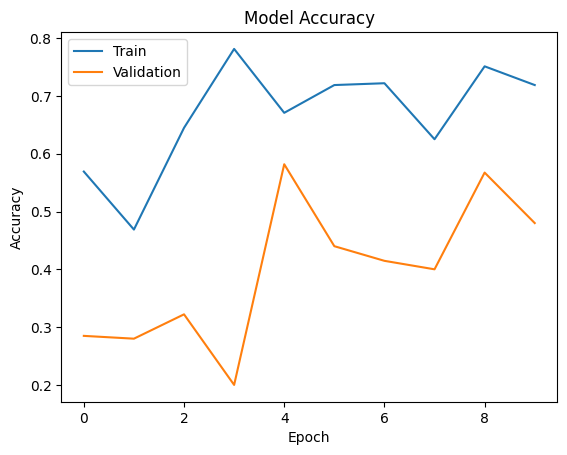

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

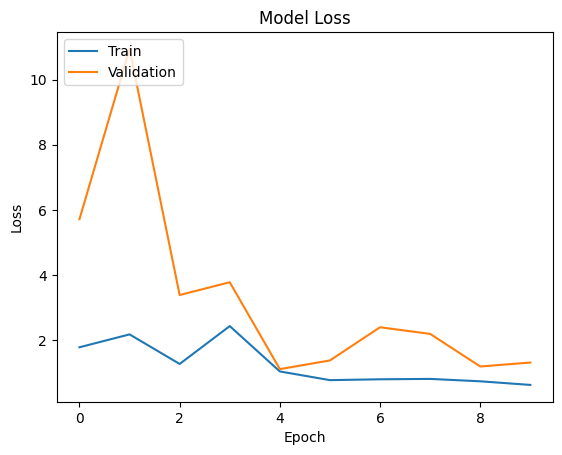

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
def evaluate_model(model, test_generator):
    #Calculate test loss and accuracy
    results = model.evaluate(test_dataset, verbose = 0)
    print(f"Test Loss = {results[0]}")
    print(f"Test Accuracy = {results[1]}")

In [ ]:
evaluate_model(model, test_dataset)

Test Loss = 1.0632991790771484
Test Accuracy = 0.5892648696899414


In [ ]:
def history_plot(epochs, history):
    fig1 = make_subplots()
    fig1.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["accuracy"], name = "Training Accuracy"))
    fig1.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["val_accuracy"], name = "Validation Accuracy"))
    fig1.update_layout(title = "Training and Validation Accuracy", xaxis_title = "Epoch", yaxis_title = "Accuracy")
    fig1.show()

    fig2 = make_subplots()
    fig2.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["loss"], name = "Training Loss"))
    fig2.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["val_loss"], name = "Validation Loss"))
    fig2.update_layout(title = "Training and Validation Loss", xaxis_title = "Epoch", yaxis_title = "Loss")
    fig2.show()

In [ ]:
history_plot(epochs, history)

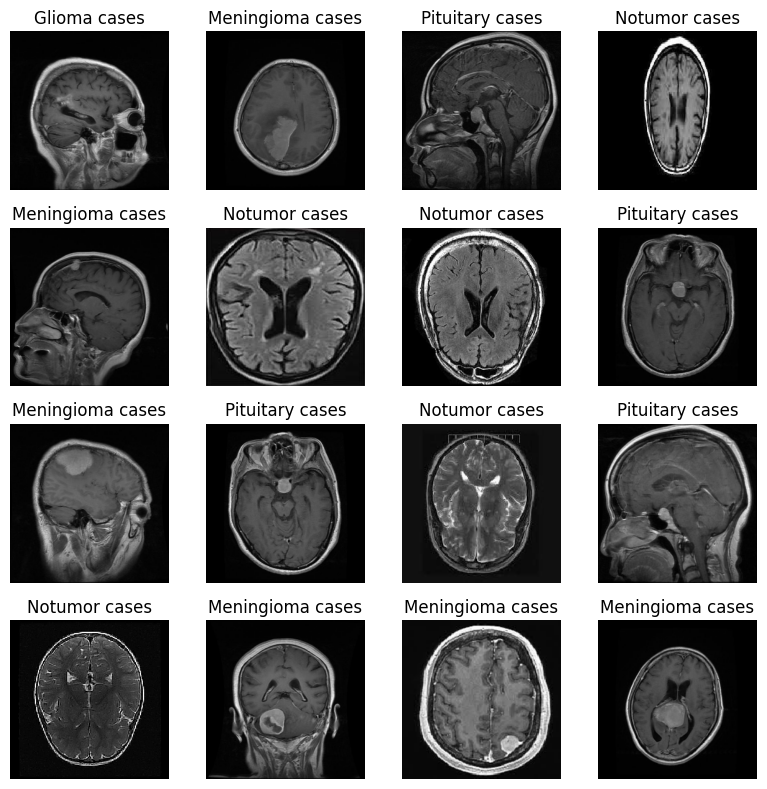

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
CONFIGURATION = {
    "IM_SIZE": 256,
   "CLASS_NAMES": ["Glioma cases", "Meningioma cases", "Notumor cases","Pituitary cases"],
}
images, labels = next(iter(test_dataset))
labels = np.argmax(labels, axis=1)
rows = 4
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
for i in range(rows * cols):
    ax = axes[i // cols, i % cols]
    ax.imshow(images[i])
    ax.set_title(CONFIGURATION['CLASS_NAMES'][labels[i]])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
CONFIGURATION = {
    "IM_SIZE": 256,
     "CLASS_NAMES": ["Glioma cases", "Meningioma cases", "Notumor cases","Pituitary cases"],
}
batch=next(test_dataset)
test_images,true_labels = batch
random_index = np.random.randint(len(test_images))
test_image = test_images[random_index]
true_label_index = tf.argmax(true_labels[random_index])

test_image = tf.image.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))
im = tf.expand_dims(test_image, axis=0)
predicted_label_index = tf.argmax(model(im), axis=-1)
print("True Label:", CONFIGURATION["CLASS_NAMES"][true_label_index.numpy()])
print("Predicted Label:", CONFIGURATION["CLASS_NAMES"][predicted_label_index[0]])

True Label: Meningioma cases
Predicted Label: Notumor cases


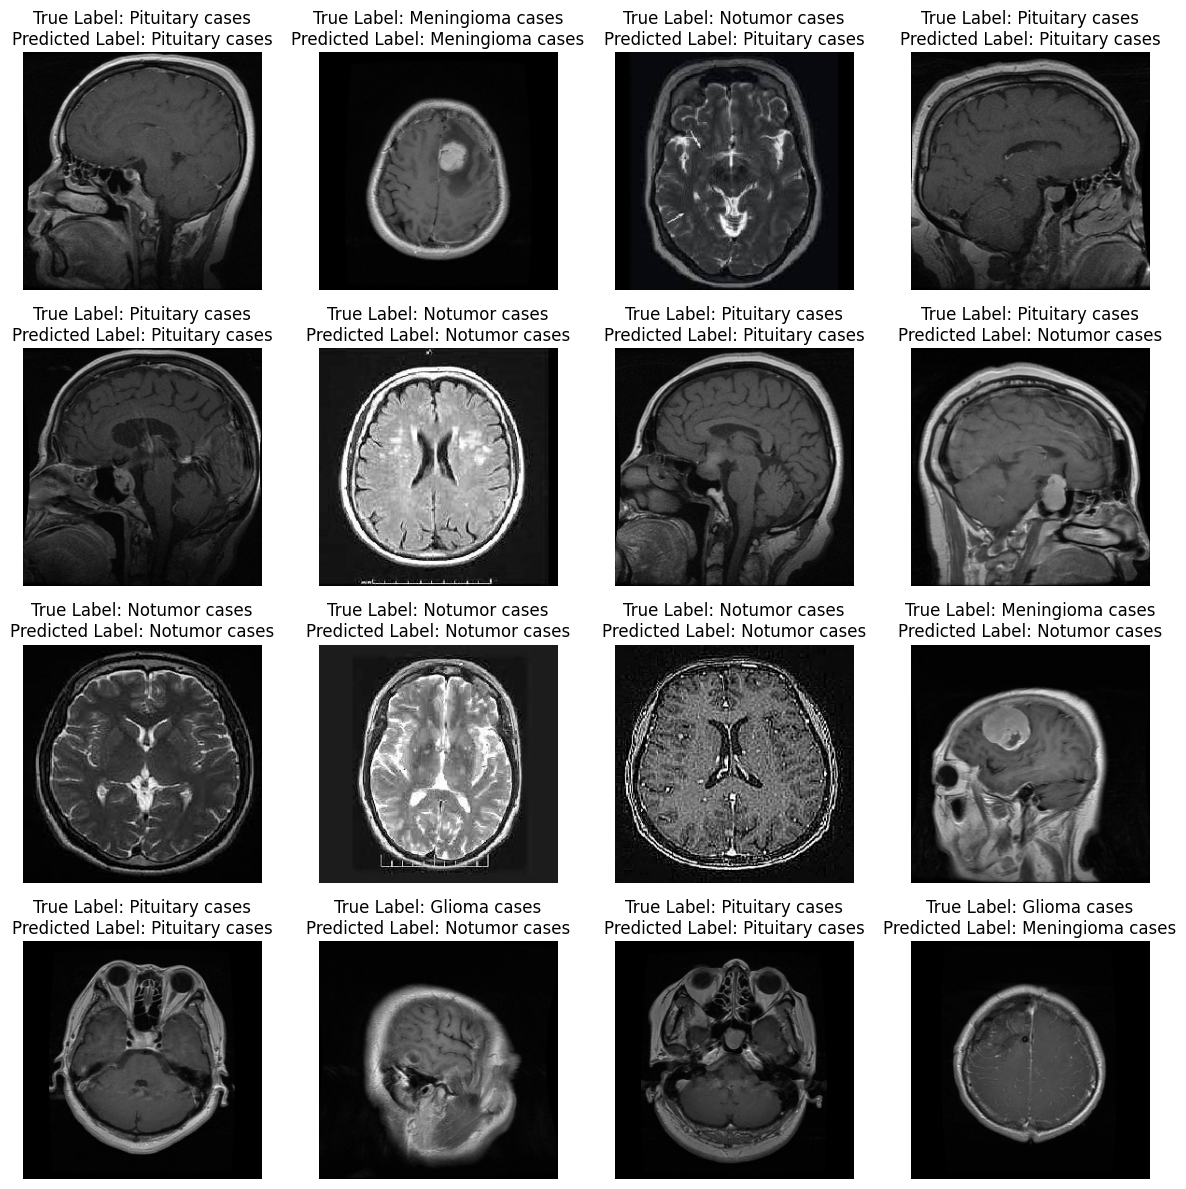

In [ ]:
images, labels = next(iter(test_dataset))
rows = 4
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
for i in range(rows * cols):
    ax = axes[i // cols, i % cols]
    ax.imshow(images[i])
    true_label_index = np.argmax(labels[i])  # Get the index of the true label for the ith image
    true_label = CONFIGURATION["CLASS_NAMES"][true_label_index]  # Get the true label name from the configuration
    predicted_label_index = np.argmax(model(tf.expand_dims(images[i], axis=0)))  # Get the index of the predicted label for the ith image
    predicted_label = CONFIGURATION["CLASS_NAMES"][predicted_label_index]  # Get the predicted label name from the configuration
    ax.set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
model.save("BCNN.keras")